In [1]:
from os import listdir
import gzip
import numpy as np
from scipy import sparse

# load genotypes
chrom = 22
gen_files = sorted([f for f in listdir('split_gen') if ('chr.%d' % chrom) in f and 'gen.npz' in f])
whole_chrom = sparse.hstack([sparse.load_npz('split_gen/%s' % gen_file) for gen_file in gen_files])
m, n = whole_chrom.shape
print(m, n)

# pull indices of snps
variant_file = 'split_gen/chr.%d.gen.variants.txt.gz' % chrom
snp_indices = []
snp_positions_all = []
with gzip.open(variant_file, 'rt') as f:
    for i, line in enumerate(f):
        pieces = line.strip().split('\t')
        if len(pieces[3]) == 1 and len(pieces[4]) == 1 and pieces[3] != '.' and pieces[4] != '.':
            snp_indices.append(i)
            snp_positions_all.append(int(pieces[1]))
snp_positions_all = np.asarray(snp_positions_all)

whole_chrom = whole_chrom[:, snp_indices]
m, n = whole_chrom.shape
print(m, n)

4610 1096535
4610 1004649


In [2]:
from os import listdir
import gzip
import numpy as np
from scipy import sparse

# load dp
dp_files = sorted([f for f in listdir('split_dp') if ('chr.%d' % chrom) in f and 'dp.npz' in f])
whole_dp = sparse.hstack([sparse.load_npz('split_dp/%s' % dp_file) for dp_file in dp_files])
m, n = whole_chrom.shape
print(m, n)

# pull indices of snps
variant_file = 'split_dp/chr.%d.dp.variants.txt.gz' % chrom
snp_indices = []
snp_positions_all = []
with gzip.open(variant_file, 'rt') as f:
    for i, line in enumerate(f):
        pieces = line.strip().split('\t')
        if len(pieces[3]) == 1 and len(pieces[4]) == 1 and pieces[3] != '.' and pieces[4] != '.':
            snp_indices.append(i)
            snp_positions_all.append(int(pieces[1]))
snp_positions_all = np.asarray(snp_positions_all)

whole_dp = whole_dp[:, snp_indices]
print(whole_chrom.shape, whole_dp.shape)

4610 1004649
(4610, 1004649) (4610, 1004649)


In [3]:
sample_file = 'split_gen/chr.%d.gen.samples.txt' % chrom
with open(sample_file, 'r') as f:
    individual_to_index = dict([(x.strip(), i) for i, x in enumerate(f)])

ped_file = '160826.ped'
# Affection (0=unknown; 1=unaffected; 2=affected)
id_to_affected = dict()
id_to_sex = dict()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
            id_to_affected[child_id] = disease_status
            id_to_sex[child_id] = sex
            id_to_sex[f_id] = '1'
            id_to_sex[m_id] = '2'
            
male_indices = [i for x, i in individual_to_index.items() if x in id_to_sex and id_to_sex[x] == '1']
female_indices = [i for x, i in individual_to_index.items() if x in id_to_sex and id_to_sex[x] != '1']
print('Male', len(male_indices), 'Female', len(female_indices))

Male 2823 Female 1773


In [4]:
# Pull cytogenetic coordinates
with open('cytoBand.txt', 'r') as f:
    xticks, xticklabels = [], []
    for line in f:
        pieces = line.strip().split()
        if pieces[0] == 'chr%s' % chrom:
            xticks.append(int(pieces[1]))
            xticklabels.append(pieces[3])

In [5]:
male_missing = np.sum(whole_chrom[male_indices, :]==-1, axis=0)
male_het = np.sum(whole_chrom[male_indices, :]==1, axis=0)
male_homalt = np.sum(whole_chrom[male_indices, :]==2, axis=0)

female_missing = np.sum(whole_chrom[female_indices, :]==-1, axis=0)
female_het = np.sum(whole_chrom[female_indices, :]==1, axis=0)
female_homalt = np.sum(whole_chrom[female_indices, :]==2, axis=0)

total_male = len(male_indices)
total_female = len(female_indices)

In [6]:
from scipy.stats import chi2_contingency

trans_to_pvalue = dict()

male_v_female_missing = np.ones((whole_chrom.shape[1],))
male_v_female_gen = np.ones((whole_chrom.shape[1],))
male_v_female_both = np.ones((whole_chrom.shape[1],))

num_tests = 0
for i in range(whole_chrom.shape[1]):
    t = (male_missing[0, i], female_missing[0, i], total_male-male_missing[0, i], total_female-female_missing[0, i])
    cont = np.asarray([[t[0], t[1]], [t[2], t[3]]])
    cont = cont[np.sum(cont, axis=1)>0, :]
    if t not in trans_to_pvalue and cont.shape[0]>1 and cont.shape[1]>1:
        try:
            trans_to_pvalue[t] = chi2_contingency([[t[0], t[1]], [t[2], t[3]]])[1]
        except ValueError:
            print(t)
    if t in trans_to_pvalue:
        male_v_female_missing[i] = trans_to_pvalue[t]
        num_tests += 1

print(-np.log10(0.01/num_tests))

num_tests = 0
for i in range(whole_chrom.shape[1]):
    t = (total_male-male_missing[0, i]-male_het[0, i]-male_homalt[0, i], 
         total_female-female_missing[0, i]-female_het[0, i]-female_homalt[0, i], 
         male_het[0, i], female_het[0, i], 
         male_homalt[0, i], female_homalt[0, i])
    
    cont = np.asarray([[t[0], t[1]], [t[2], t[3]], [t[4], t[5]]])
    cont = cont[np.sum(cont, axis=1)>0, :]
    if t not in trans_to_pvalue and cont.shape[0]>1 and cont.shape[1]>1:
        try:
            trans_to_pvalue[t] = chi2_contingency(cont)[1]
        except ValueError:
            print(t)
    if t in trans_to_pvalue:
        male_v_female_gen[i] = trans_to_pvalue[t]
        num_tests += 1
print(-np.log10(0.01/num_tests))

num_tests = 0
for i in range(whole_chrom.shape[1]):
    t = (total_male-male_missing[0, i]-male_het[0, i]-male_homalt[0, i], 
         total_female-female_missing[0, i]-female_het[0, i]-female_homalt[0, i], 
         male_het[0, i], female_het[0, i], 
         male_homalt[0, i], female_homalt[0, i],
         male_missing[0, i], female_missing[0, i])
    
    cont = np.asarray([[t[0], t[1]], [t[2], t[3]], [t[4], t[5]], [t[6], t[7]]])
    cont = cont[np.sum(cont, axis=1)>0, :]
    if t not in trans_to_pvalue and cont.shape[0]>1 and cont.shape[1]>1:
        try:
            trans_to_pvalue[t] = chi2_contingency(cont)[1]
        except ValueError:
            print(t)
    if t in trans_to_pvalue:
        male_v_female_both[i] = trans_to_pvalue[t]
        num_tests += 1
print(-np.log10(0.01/num_tests))


7.04781593767
(0, 3, 0, 2, 0, 0)
(3, 0, 1, 0, 0, 0)
(5, 0, 0, 0, 1, 0)
(3, 0, 0, 0, 2, 0)
(0, 142, 0, 1, 0, 0)
(0, 47, 0, 1, 0, 0)
(0, 41, 0, 0, 0, 1)
(0, 2, 0, 1, 0, 0)
(0, 725, 0, 1, 0, 0)
(0, 301, 0, 3, 0, 0)
(0, 0, 0, 8, 0, 1)
(0, 0, 1, 0, 1, 0)
(0, 0, 1, 0, 1, 0)
8.00164243217
8.00168958902


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


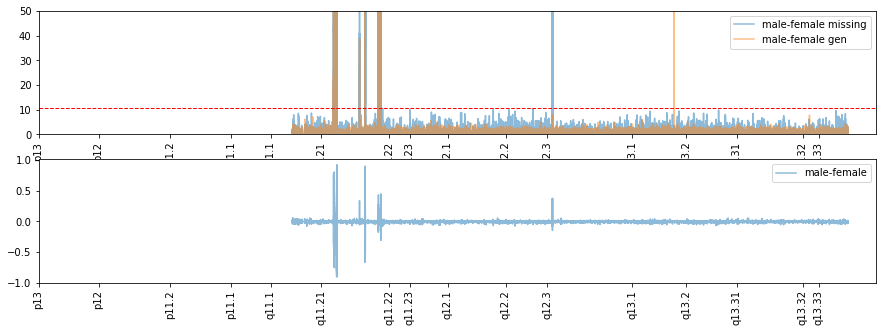

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

plt.subplot(2, 1, 1)
plt.plot(snp_positions_all, -np.log10(male_v_female_missing), alpha=0.5, label='male-female missing')
plt.plot(snp_positions_all, -np.log10(male_v_female_gen), alpha=0.5, label='male-female gen')
#plt.plot(snp_positions_all, -np.log10(male_v_female_both), alpha=0.5, label='male-female both')

plt.axhline(y=-np.log10(0.01/(num_tests*6*100)), linewidth=1, linestyle='--', color='r')
plt.ylim(0, 50)
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(snp_positions_all, np.ravel(male_missing)/total_male - np.ravel(female_missing)/total_female, alpha=0.5, label='male-female')

plt.xticks(xticks, xticklabels, rotation='vertical')
plt.legend()

plt.show()

In [51]:
plt.figure(figsize=(15, 5))
is_sig = -np.log10(male_v_female_both) >= 15
all_sig = -np.log10(male_v_female_both) >= 15
for i in range(2):
    all_sig[np.where(is_sig[(i+1):])[0]] = True
    all_sig[(i+1) + np.where(is_sig[:-(i+1)])[0]] = True
    
peaks = list(zip(np.where(~all_sig[:-1] & all_sig[1:])[0], np.where(all_sig[:-1] & ~all_sig[1:])[0]))
print(len(peaks))
print(peaks)

21
[(36725, 36734), (136509, 136527), (136528, 136547), (136549, 136563), (136589, 136598), (136604, 136664), (136669, 136698), (136699, 136704), (136713, 136746), (136750, 136755), (136758, 136783), (136785, 136804), (136805, 136810), (136814, 136821), (258374, 258391), (351958, 352001), (707706, 707711), (707725, 707734), (746996, 747001), (793562, 793571), (793573, 793579)]


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


136758 136783
11187531 11187817
64.7614314611
[[1144 1182]
 [   1    1]
 [   0    0]
 [1678  590]]
[[  4.05242650e-01   6.66666667e-01]
 [  3.54233085e-04   5.64015792e-04]
 [  0.00000000e+00   0.00000000e+00]
 [  5.94403117e-01   3.32769318e-01]]
228.717060252
[[ 461 1119]
 [   1    2]
 [   1    1]
 [2360  651]]
[[  1.63301452e-01   6.31133672e-01]
 [  3.54233085e-04   1.12803158e-03]
 [  3.54233085e-04   5.64015792e-04]
 [  8.35990081e-01   3.67174281e-01]]
244.680494484
[[ 322 1025]
 [   2    2]
 [   1    0]
 [2498  746]]
[[  1.14063053e-01   5.78116187e-01]
 [  7.08466171e-04   1.12803158e-03]
 [  3.54233085e-04   0.00000000e+00]
 [  8.84874247e-01   4.20755781e-01]]
61.0981653419
[[ 132  365]
 [ 863  440]
 [ 125   73]
 [1703  895]]
[[ 0.04675877  0.20586576]
 [ 0.30570315  0.24816695]
 [ 0.04427914  0.04117315]
 [ 0.60325894  0.50479413]]
52.6125515529
[[  67  255]
 [   1    2]
 [   0    0]
 [2755 1516]]
[[  2.37336167e-02   1.43824027e-01]
 [  3.54233085e-04   1.12803158e-03]
 [ 

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


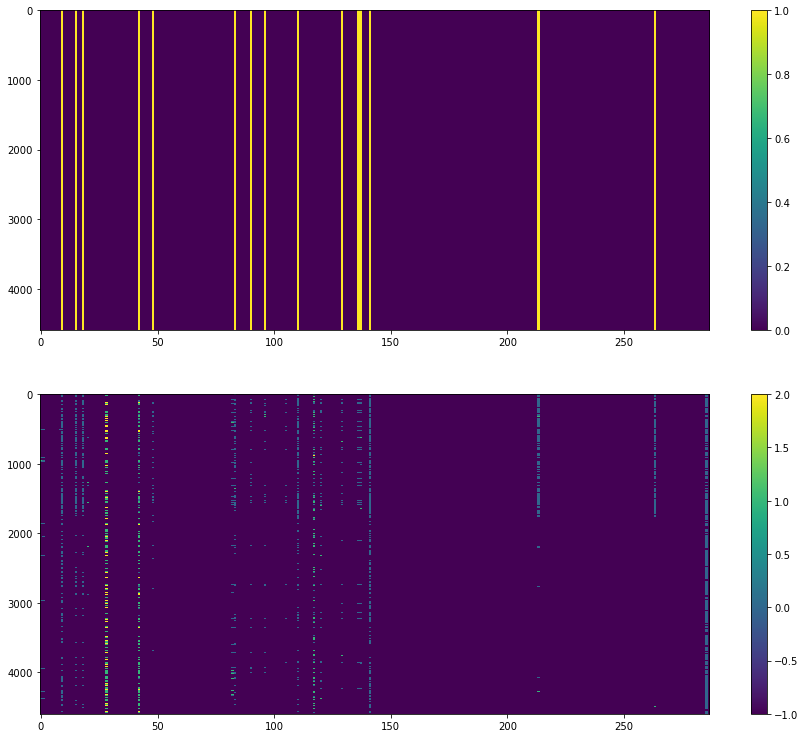

In [64]:
peak_index = 10
start_index, stop_index = peaks[peak_index]
start_pos, end_pos = snp_positions_all[start_index], snp_positions_all[stop_index]
print(start_index, stop_index)
print(start_pos, end_pos)

for i in range(start_index, stop_index+1):
    if is_sig[i]:
        t = (total_male-male_missing[0, i]-male_het[0, i]-male_homalt[0, i], 
             total_female-female_missing[0, i]-female_het[0, i]-female_homalt[0, i], 
            male_het[0, i], female_het[0, i], 
             male_homalt[0, i], female_homalt[0, i],
            male_missing[0, i], female_missing[0, i])
    
        cont = np.reshape(t, (4, 2))
        print(-np.log10(male_v_female_both[i]))
        print(cont)
        print(cont/np.sum(cont, axis=0))

sig_region = np.zeros((m, end_pos-start_pos+1))
sig_region[:, snp_positions_all[start_index:stop_index]-start_pos] = np.outer(np.ones(m,), is_sig[start_index:stop_index])

gen_region = np.zeros((m, end_pos-start_pos+1))-1
gen_region[:, snp_positions_all[start_index:stop_index]-start_pos] = whole_chrom[:, start_index:stop_index].A

dp_region = np.zeros((m, end_pos-start_pos+1))-1
dp_region[:, snp_positions_all[start_index:stop_index]-start_pos] = whole_dp[:, start_index:stop_index].A
dp_region[dp_region == 0] = 20

plt.figure(figsize=(15, 20))

plt.subplot(3, 1, 1)
plt.imshow(sig_region[female_indices + male_indices, :], aspect='auto')
plt.colorbar()

plt.subplot(3, 1, 2)
plt.imshow(gen_region[female_indices + male_indices, :], aspect='auto')
plt.colorbar()

#plt.subplot(3, 1, 3)
#plt.imshow(dp_region[female_indices + male_indices, :], aspect='auto')
#plt.colorbar()

plt.show()

In [54]:
print(np.outer(np.ones(m,), is_sig[start_index:stop_index]).shape)

(4610, 60)
